In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file='drive/MyDrive/libgcrypt-modpow-branchless.csv'
units = ['EUU-ALU', 'LQ-ADDR', 'SQ-ADDR', 'LQ-PC', 'SQ-PC', 'ROB-PC']
unit = 'SQ-ADDR'
iterss = 100
category='V2'
type_='warmup'

In [ ]:
#prepare column
def make_column_name(base,size):
    arr_name=[]
    for i in range(size):
        arr_name.append(base+'_'+str(i))
    return arr_name

LQ_PC_arr=make_column_name('LQ_PC', 8)
LQ_ADDR_arr=make_column_name('LQ_ADDR',8)
SQ_PC_arr=make_column_name('SQ_PC',8)
SQ_ADDR_arr=make_column_name('SQ_ADDR',8)

ROB_PC_arr=make_column_name('ROB_PC',32)
LFB_DATA_arr = make_column_name('LFB_DATA',16)
#EUU_BITVEC_arr = make_column_name('EUU_BITVEC',4)
EUU_ALU_arr = make_column_name('EUU_ALU',2)
EUU_ADDRG_arr = make_column_name('EUU_ADDRG',1)
EUU_DIV_arr = make_column_name('EUU_DIV',1)
EUU_MUL_arr = make_column_name('EUU_MUL',1)

super_column = ['LQ-OCPNCY', 'LQ-PC', 'LQ-ADDR', 'SQ-OCPNY', 'SQ-PC', 'SQ-ADDR',
       'ROB-OCPNY', 'ROB-PC', 'LFB-DATA', 'EUU-ALU', 'EUU-ADDRG','EUU-DIV','EUU-MUL','PREF-ADDR'
       , 'CLASS', 'ITER', 'KEY', 'DTLB-NMISS', 'DCACHE-NMISS']

super_column_group = [['LQ-OCPNCY'], LQ_PC_arr, LQ_ADDR_arr, ['SQ-OCPNY'], SQ_PC_arr, SQ_ADDR_arr,
       ['ROB-OCPNY'], ROB_PC_arr, LFB_DATA_arr, EUU_ALU_arr, EUU_ADDRG_arr, EUU_DIV_arr, EUU_MUL_arr,
                      ['PREF-ADDR'],['CLASS'], ['ITER'],['KEY'], ['DTLB-NMISS'], ['DCACHE-NMISS']]

# super_column = ['CYCLE', 'LQ-OCPNCY', 'LQ-PC', 'LQ-ADDR', 'SQ-OCPNY', 'SQ-PC', 'SQ-ADDR',
#        'ROB-OCPNY', 'ROB-PC', 'LFB-DATA', 'EUU-ALU', 'EUU-ADDRG','EUU-DIV','EUU-MUL','PREF-ADDR'
#        , 'CLASS', 'ITER', 'KEY', 'DTLB-NMISS', 'DCACHE-NMISS']

# super_column_group = [['CYCLE'], ['LQ-OCPNCY'], LQ_PC_arr, LQ_ADDR_arr, ['SQ-OCPNY'], SQ_PC_arr, SQ_ADDR_arr,
#        ['ROB-OCPNY'], ROB_PC_arr, LFB_DATA_arr, EUU_ALU_arr, EUU_ADDRG_arr, EUU_DIV_arr, EUU_MUL_arr,
#                       ['PREF-ADDR'],['CLASS'], ['ITER'],['KEY'], ['DTLB-NMISS'], ['DCACHE-NMISS']]
sub_column=[]
for arr in super_column_group:
    sub_column.extend(arr)

standard_scaling_feature=['LQ-OCPNCY','SQ-OCPNY','ROB-OCPNY']
PC_features=['LQ-PC', 'SQ-PC','ROB-PC']
add_features=['LQ-ADDR','SQ-ADDR','PREF-ADDR']
euu_features=['EUU-ALU', 'EUU-ADDRG','EUU-DIV','EUU-MUL']

df = pd.read_csv(file,sep=',',names = sub_column,header=1)#[0:1000]
#df.head()
#print(sub_column)

In [ ]:
df_list=[]
for i,group in enumerate(super_column_group):
    temp_df = df[group]
    temp_df.columns = pd.MultiIndex.from_product([[super_column[i]], temp_df.columns])
    #display(temp_df.head())
    df_list.append(temp_df)
new_df = pd.concat(df_list,axis=1)
new_df.drop([('LFB-DATA',), ('DTLB-NMISS',), ('DCACHE-NMISS',)],axis=1,inplace=True)
#new_df.head()

<ipython-input-27-65673bba902a>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  new_df.drop([('LFB-DATA',), ('DTLB-NMISS',), ('DCACHE-NMISS',)],axis=1,inplace=True)


In [ ]:
new_df = new_df[[unit, 'CLASS', 'ITER', 'KEY']]
subsets=[]
for items in new_df[unit]:
    subsets.append((unit, items))
#new_df = new_df.dropna(subset=subsets, how='all')
new_df.fillna('0x00',inplace=True)
#new_df.head()

In [ ]:
addr_dict={}
def addr_dict_maker(x):
    addr_dict[x]=None

new_df[unit].applymap(addr_dict_maker)
ind=1
for i,key in enumerate(addr_dict):
    if key!='0x00':
        addr_dict[key] = ind
        ind+=1
    elif key=='0x00':
        addr_dict[key] = 0

print("Feature Dictionary:")
addr_dict

In [ ]:
# unique_values = [keys for keys in addr_dict]
# count_dict = {value: {0: 0, 1: 0} for value in unique_values}
# count_dict

# for _, row in new_df.iterrows():
#     a, b, c, d, e, f, g, h, i = row[('SQ-PC', 'SQ_PC_0')], row[('SQ-PC', 'SQ_PC_1')], row[('SQ-PC', 'SQ_PC_2')], row[('SQ-PC', 'SQ_PC_3')], row[('SQ-PC', 'SQ_PC_4')], row[('SQ-PC', 'SQ_PC_5')], row[('SQ-PC', 'SQ_PC_6')], row[('SQ-PC', 'SQ_PC_7')], row[('CLASS', 'CLASS')]
#     count_dict[a][i] += 1
#     count_dict[b][i] += 1
#     count_dict[c][i] += 1
#     count_dict[d][i] += 1
#     count_dict[e][i] += 1
#     count_dict[f][i] += 1
#     count_dict[g][i] += 1
#     count_dict[h][i] += 1

# count_dict

# {'0x00': {0: 847428, 1: 780552},
#  '0x102bc': {0: 76659, 1: 73083},
#  '0x121e2': {0: 860, 1: 781},
#  '0x104cc': {0: 1672, 1: 1745},
#  '0x103f8': {0: 2459, 1: 2598},
#  '0x10356': {0: 3608, 1: 3218},
#  '0x10e2c': {0: 9574, 1: 8992},
#  '0x102fa': {0: 44, 1: 23}}

# for k in count_dict:
#     print(count_dict[k][0]/(count_dict[k][0]+count_dict[k][1]), count_dict[k][1]/(count_dict[k][0]+count_dict[k][1]))

# count_dict


In [ ]:
itr = [i for i in range(iterss)]
keys = ['0x44','0xaa','rand-0.10_0.90','rand-0.20_0.80','rand-0.30_0.70','rand-0.40_0.60','rand-0.50_0.50',
        'rand-0.60_0.40','rand-0.70_0.30','rand-0.80_0.20','rand-0.90_0.10']
#keys = ['rand-0.50_0.50']
c=0
i=0
X_inp = {}
Y_inp = {}
for k in keys:
    X_inp[k] = []
    Y_inp[k] = []

tmp=[]
curr_key = keys[0]
curr_iter = 0

for i in range(len(new_df)):
    if(new_df[('KEY','KEY')].iloc[i]!=curr_key):
        X_inp[curr_key].append(np.array(tmp))
        Y_inp[curr_key].append(np.array([new_df[('CLASS','CLASS')].iloc[i-1]]))
        curr_key = new_df[('KEY','KEY')].iloc[i]
        curr_iter = new_df[('ITER','ITER')].iloc[i]
        tmp=[]
        #break
    if(new_df[('ITER','ITER')].iloc[i]!=curr_iter):
        curr_iter = new_df[('ITER','ITER')].iloc[i]
        X_inp[curr_key].append(np.array(tmp))
        Y_inp[curr_key].append(np.array([new_df[('CLASS','CLASS')].iloc[i-1]]))
        tmp=[]
    if unit == 'EUU-ALU':
      tmp.append([addr_dict[new_df[('EUU-ALU','EUU_ALU_0')].iloc[i]],
                 addr_dict[new_df[('EUU-ALU','EUU_ALU_1')].iloc[i]],])
    elif unit == 'LQ-ADDR':
      tmp.append([addr_dict[new_df[('LQ-ADDR','LQ_ADDR_0')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_1')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_2')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_3')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_4')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_5')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_6')].iloc[i]],
                  addr_dict[new_df[('LQ-ADDR','LQ_ADDR_7')].iloc[i]],])
    elif unit == 'SQ-ADDR':
      tmp.append([addr_dict[new_df[('SQ-ADDR','SQ_ADDR_0')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_1')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_2')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_3')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_4')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_5')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_6')].iloc[i]],
                addr_dict[new_df[('SQ-ADDR','SQ_ADDR_7')].iloc[i]],])
    elif unit == 'LQ-PC':
      tmp.append([addr_dict[new_df[('LQ-PC','LQ_PC_0')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_1')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_2')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_3')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_4')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_5')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_6')].iloc[i]],
            addr_dict[new_df[('LQ-PC','LQ_PC_7')].iloc[i]],])
    elif unit == 'SQ-PC':
      tmp.append([addr_dict[new_df[('SQ-PC','SQ_PC_0')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_1')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_2')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_3')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_4')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_5')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_6')].iloc[i]],
            addr_dict[new_df[('SQ-PC','SQ_PC_7')].iloc[i]],])

    elif unit == 'ROB-PC':
      tmp.append([addr_dict[new_df[('ROB-PC','ROB_PC_0')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_1')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_2')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_3')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_4')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_5')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_6')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_7')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_8')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_9')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_10')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_11')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_12')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_13')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_14')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_15')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_16')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_17')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_18')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_19')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_20')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_21')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_22')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_23')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_24')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_25')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_26')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_27')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_28')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_29')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_30')].iloc[i]],
           addr_dict[new_df[('ROB-PC','ROB_PC_31')].iloc[i]],])


print (curr_key)
X_inp[curr_key].append(np.array(tmp))
Y_inp[curr_key].append(np.array([new_df[('CLASS','CLASS')].iloc[i-1]]))
print('Done')


rand-0.90_0.10
Done


In [ ]:
m = -1
for keys in X_inp:
    for i in range(iterss):
        #print(keys, X_inp[keys][i].shape, Y_inp[keys][i])
        if(m<X_inp[keys][i].shape[0]):
            m=X_inp[keys][i].shape[0]

print('max cycle: ', m)
#print('sample: ', X_inp['0x44'][0].shape[0])

m1 = X_inp['rand-0.50_0.50'][0].shape[0]

for keys in X_inp:
    for i in range(iterss):
        #print(keys, X_inp[keys][i].shape, Ys_inp[keys][i])
        if(m1>X_inp[keys][i].shape[0]):
            m1=X_inp[keys][i].shape[0]

print('min cycle: ', m1)
print('sample: ', X_inp['rand-0.50_0.50'][0].shape[0])

max cycle:  198
min cycle:  84
sample:  173


In [ ]:
#max
for keys in X_inp:
    for i in range(iterss):
        for j in range(m - X_inp[keys][i].shape[0]):
            tmp=[]
            for k in range(X_inp[keys][i].shape[1]):
                tmp.append(0)
            X_inp[keys][i] = np.append(X_inp[keys][i], [tmp], axis=0)

#for keys in X_inp:
    #for i in range(iterss):
        #print(keys, X_inp[keys][i].shape, Y_inp[keys][i])

In [ ]:
#min

# for keys in X_inp:
#     for i in range(100):
# #         for j in range(m - X_inp[keys][i].shape[0]):
# #             tmp=[]
# #             for k in range(X_inp[keys][i].shape[1]):
# #                 tmp.append(0)
#             X_inp[keys][i] = X_inp[keys][i][:m1]

# for keys in X_inp:
#     for i in range(100):
#         print(keys, X_inp[keys][i].shape, Y_inp[keys][i])

In [ ]:
groups = new_df.groupby([('ITER','ITER'),('KEY','KEY')])
count=[]
for i,table in groups:
    #print(i, table.shape[0])
    count.append(table.shape[0])
#count
#count = np.array(count)
#avg_cycle, max_cycle, min_cycle=int(np.mean(count)), int(np.max(count)), int(np.min(count))
#count, avg_cycle, max_cycle, min_cycle

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
train_series = ['0xaa','0x44','rand-0.20_0.80','rand-0.80_0.20','rand-0.40_0.60','rand-0.60_0.40','rand-0.10_0.90','rand-0.90_0.10',
                'rand-0.30_0.70','rand-0.70_0.30','rand-0.50_0.50']
#train_series = ['rand-0.50_0.50']
test_series = ['rand-0.30_0.70','rand-0.70_0.30','rand-0.50_0.50']
X_train=[]
X_test=[]
y_train=[]
y_test=[]

for k in train_series:
    for i in range(iterss):
        X_train.append(X_inp[k][i])
        y_train.append(Y_inp[k][i])

#for k in test_series:
#    for i in range(2000):
#        X_test.append(X_inp[k][i])
#        y_test.append(Y_inp[k][i])

X_train = np.array(X_train)
y_train = np.array(y_train)
#X_test = np.array(X_test)
#y_test = np.array(y_test)
print(y_train.shape)
y_train = y_train.reshape(iterss, -1).ravel()

print(X_train.shape)






(1100, 1)
(1100, 198, 8)


In [ ]:
# THIS IS ONLY TO GET RID OF TIMING
max_length_unique = 0
print(X_train.shape)
print(y_train.shape)
for i, arr in enumerate(X_train):
    flattened_array = arr.flatten(order='F')
    unique_elements = flattened_array[flattened_array != 0]
    if (len(unique_elements) == 0):
      unique_elements = np.array([0])
    result = [unique_elements[0]]
    # Iterate through the array and add values to the result list
    for value in unique_elements[1:]:
        if value != result[-1]:
            result.append(value)
    # Convert the result list back to a NumPy array
    result = np.array(result)
    max_length_unique = max(max_length_unique, len(result))

x_train = []
for i, arr in enumerate(X_train):
    flattened_array = arr.flatten(order='F')
    unique_elements = flattened_array[flattened_array != 0]
    #unique_elements = np.sort(unique_elements)
    if (len(unique_elements) == 0):
      unique_elements = np.array([0])
    result = [unique_elements[0]]
    # Iterate through the array and add values to the result list
    for value in unique_elements[1:]:
        if value != result[-1]:
            result.append(value)
    # Convert the result list back to a NumPy array
    result = np.array(result)
    reshaped_array = np.zeros(max_length_unique)
    reshaped_array[:len(result)] = result
    #sorted_flattened_array = np.sort(reshaped_array)
    x_train.append(reshaped_array)

X_train = np.array(x_train)
X_train = X_train.reshape(1100, max_length_unique, 1)
print(X_train.shape)

(1100, 39, 1)
(1100,)
(1100, 39, 1)


In [ ]:
import numpy as np


data = X_train
labels = y_train

# Separate the data based on the labels
data_label_1 = data[y_train == 1]
data_label_0 = data[y_train == 0]

# Flatten the arrays corresponding to each label
flattened_data_label_1 = data_label_1.flatten()
flattened_data_label_0 = data_label_0.flatten()

# Find unique values in each label
unique_values_label_1 = np.unique(flattened_data_label_1)
unique_values_label_0 = np.unique(flattened_data_label_0)

# Find values unique to label 1
values_unique_to_label_1 = np.setdiff1d(unique_values_label_1, unique_values_label_0)

# Find values unique to label 0
values_unique_to_label_0 = np.setdiff1d(unique_values_label_0, unique_values_label_1)

print("Store queue address IDs unique to Key bit 1:")
print(values_unique_to_label_1)

print("Store queue address IDs unique to Key bit 0:")
print(values_unique_to_label_0)

print("Feature Dictionary:")
addr_dict

NameError: name 'X_train' is not defined

In [ ]:
hashable_arrays = [tuple(map(tuple, arr)) for arr in X_train]

# Create a dictionary to store the unique scalar values for each array
array_to_scalar = {}

# Generate unique scalar values for each array
for arr in hashable_arrays:
    if arr not in array_to_scalar:
        array_to_scalar[arr] = hash(arr)
X_scalar = np.array([array_to_scalar[tuple(map(tuple, arr))] for arr in X_train])

print(X_scalar[1])
#print(X_train.shape)
print(X_scalar.shape)
print(y_train.shape)

-3439401468239530111
(1100,)
(1100,)


(1100,)
[0 1 0 ... 0 1 1]
Number of unique values: 141


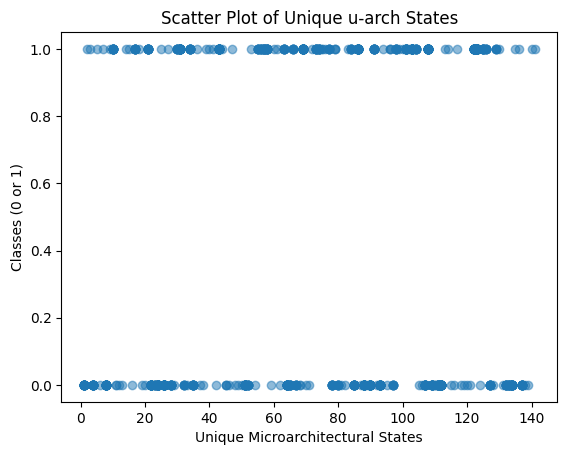

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Get unique values and their indices
unique_values, unique_indices = np.unique(X_scalar, return_inverse=True)

# Create a dictionary to store the mapping of unique values to IDs
value_to_id = {value: idx + 1 for idx, value in enumerate(unique_values)}

# Map the values to IDs
X_id = np.array([value_to_id[value] for value in X_scalar])
print(X_id.shape)
print(y_train)
num_unique_values = len(unique_values)
print("Number of unique values:", num_unique_values)

# Create a scatter plot
plt.scatter(X_id, y_train, alpha=0.5)  # Scatter the points

# Set plot labels and title
plt.xlabel("Unique Microarchitectural States")
plt.ylabel("Classes (0 or 1)")
plt.title("Scatter Plot of Unique u-arch States")

# Show the plot
plt.show()



In [ ]:
from tabulate import tabulate
import scipy.stats as stats
# Create dictionaries to store counts for labels 0 and 1
count_0 = {}
count_1 = {}

# Iterate through the vector and labels to count occurrences
for value, label in zip(X_id, y_train):
    if label == 0:
        if value in count_0:
            count_0[value] += 1
        else:
            count_0[value] = 1
    elif label == 1:
        if value in count_1:
            count_1[value] += 1
        else:
            count_1[value] = 1

# Get the 10 values with the most count for label 0
top_10_values_0 = sorted(count_0, key=count_0.get, reverse=True)[:10]

# Get the 10 values with the most count for label 1
top_10_values_1 = sorted(count_1, key=count_1.get, reverse=True)[:10]


contingency_table = []
row0 = []
row1 = []

# Prepare the data for the table
table_data = []
for value in set(X_id):  # Use set to ensure unique values
    count_label_0 = count_0.get(value, 0)
    count_label_1 = count_1.get(value, 0)
    # Create a contingency table with counts of IDs for class 0 and class 1
    row0.append(count_label_0)
    row1.append(count_label_1)
    table_data.append([value, count_label_0, count_label_1])

# Define the headers
headers = ["Microarchitectural State", "Count (Key bit 0)", "Count (Key bit 1)"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="left"))




#print(row0)
contingency_table.append(row0)
contingency_table.append(row1)
#print(contingency_table)


# Create an array with two rows and 1100 columns
#contingency_table = np.zeros((2, 1100))

# Set the values in an alternating pattern
#contingency_table[0, ::2] = 1  # Set 1 in the first row, starting from the first column
#contingency_table[1, 1::2] = 1
#print(contingency_table)


'''
# Print all the shared hashes
print("Here are all the shared hashes and their values")
for value in set(X_id):  # Use set to ensure unique values
    count_label_0 = count_0.get(value, 0)
    count_label_1 = count_1.get(value, 0)
    if (count_label_1 > 0 and count_label_0 > 0):
      print(f"{value} | {count_label_0} | {count_label_1}") '''

contingency_table = np.array(contingency_table)
 # Perform the Chi-squared test for independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Set your significance level (alpha)
alpha = 0.05
N = np.sum(contingency_table)

# Calculate Cramér's V
k = contingency_table.shape[0]
r = contingency_table.shape[1]
cramer_v = np.sqrt(chi2 / (N * (k - 1)))

# Calculate Cramér's V with bias correction

k = k - ((k - 1)**2) / (N - 1)
r = r - ((r - 1)**2) / (N - 1)
chi2_bar = max(0, cramer_v - (((k - 1) * (r - 1)) / (N - 1)))
cramer_v_unbiased = np.sqrt(chi2_bar / min(k-1, r-1))




# Apply Yates's correction
# Initialize an array for Yates's corrections for each cell
corrections = np.zeros_like(contingency_table, dtype=float)

# Apply Yates's correction to each cell
for i in range(contingency_table.shape[0]):
    for j in range(contingency_table.shape[1]):
        corrections[i, j] = ((abs(contingency_table[i, j] - expected[i, j]) - 0.5)**2) / expected[i, j]

# Apply the corrections to the chi-squared statistic
chi2_corrected = corrections.sum()

# Calculate the p-value with Yates's correction
p_corrected = 1 - stats.chi2.cdf(chi2_corrected, dof)

#print("Chi-squared (corrected):", chi2_corrected)
#print("P-value (corrected):", p_corrected)






print("Cramér's V:", cramer_v)
#print("Cramér's V Unbiased:", cramer_v_unbiased)
#print("chai2: ", chi2)
#print ("p-value: ", p)
#print ("degree of freedom: ", dof)
# Compare the p-value to the significance level
if cramer_v > 0.25:
    print("There is a statistically significant association between IDs and class labels.")
else:
    print("There is no statistically significant association between IDs and class labels.")


+----------------------------+---------------------+---------------------+
|   Microarchitectural State |   Count (Key bit 0) |   Count (Key bit 1) |
+============================+=====================+=====================+
|                          1 |                  21 |                   0 |
+----------------------------+---------------------+---------------------+
|                          2 |                   0 |                   1 |
+----------------------------+---------------------+---------------------+
|                          3 |                   0 |                   1 |
+----------------------------+---------------------+---------------------+
|                          4 |                  19 |                   0 |
+----------------------------+---------------------+---------------------+
|                          5 |                   0 |                   1 |
+----------------------------+---------------------+---------------------+
|                        

In [ ]:
import numpy as np


data = X_train
labels = y_train

# Separate the data based on the labels
data_label_1 = data[y_train == 1]
data_label_0 = data[y_train == 0]

# Flatten the arrays corresponding to each label
flattened_data_label_1 = data_label_1.flatten()
flattened_data_label_0 = data_label_0.flatten()

# Find unique values in each label
unique_values_label_1 = np.unique(flattened_data_label_1)
unique_values_label_0 = np.unique(flattened_data_label_0)

# Find values unique to label 1
values_unique_to_label_1 = np.setdiff1d(unique_values_label_1, unique_values_label_0)

# Find values unique to label 0
values_unique_to_label_0 = np.setdiff1d(unique_values_label_0, unique_values_label_1)

print("Store queue address IDs unique to Key bit 1:")
print(values_unique_to_label_1)

print("Store queue address IDs unique to Key bit 0:")
print(values_unique_to_label_0)

print("Feature Dictionary:")
addr_dict

Store queue address IDs unique to Key bit 1:
[13 14 15 16 17 18 19 20 32 33 34 35 36 37 38 40]
Store queue address IDs unique to Key bit 0:
[ 2  4  7  8  9 10 11 12 23 24 26 27 28 29 30 39]
Feature Dictionary:


{'0x00': 0,
 '0x800a5716': 1,
 '0x800a5950': 2,
 '0x800a5715': 3,
 '0x800a5951': 4,
 '0x800a5714': 5,
 '0x800a5710': 6,
 '0x800a5953': 7,
 '0x800a5954': 8,
 '0x800a5955': 9,
 '0x800a5956': 10,
 '0x800a5957': 11,
 '0x800a5952': 12,
 '0x800a58c0': 13,
 '0x800a58c1': 14,
 '0x800a58c2': 15,
 '0x800a58c3': 16,
 '0x800a58c5': 17,
 '0x800a58c6': 18,
 '0x800a58c7': 19,
 '0x800a58c4': 20,
 '0x800a5724': 21,
 '0x800a5725': 22,
 '0x800a5961': 23,
 '0x800a5962': 24,
 '0x800a5720': 25,
 '0x800a5963': 26,
 '0x800a5964': 27,
 '0x800a5965': 28,
 '0x800a5966': 29,
 '0x800a5967': 30,
 '0x800a5726': 31,
 '0x800a58d0': 32,
 '0x800a58d2': 33,
 '0x800a58d3': 34,
 '0x800a58d4': 35,
 '0x800a58d5': 36,
 '0x800a58d6': 37,
 '0x800a58d7': 38,
 '0x800a5960': 39,
 '0x800a58d1': 40}

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Conv1D(6, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)


Epoch 1/10
25/25 [==============================] - 1s 8ms/step - loss: 0.9641 - accuracy: 0.5850
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - loss: 0.4892 - accuracy: 0.7638
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.3393 - accuracy: 0.8975
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.1840 - accuracy: 0.9575
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9862
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0454 - accuracy: 0.9937
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0305 - accuracy: 0.9950
Epoch 8/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9975
Epoch 9/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9975
Epoch 10/10
10/10 [==============================] - 0s 5ms/step - loss: 0.8542 - accuracy: 0.7700
Test accuracy: 0.76

In [ ]:
import numpy as np
import scipy.stats as stats
num_rows = 4
num_cols = 400

# Create a 2D numpy array to represent the contingency table
contingency_table = np.zeros((num_rows, num_cols), dtype=int)

# Iterate over each column and set one random cell to 1
for j in range(num_cols):
    row = np.random.randint(0, num_rows)  # Randomly select a row
    contingency_table[row, j] = 1

# Display the dimensions of the contingency table
print("Contingency table dimensions:", num_rows, "rows x", num_cols, "columns")


print("Contingency table:")
print(contingency_table)

In [ ]:
import numpy as np




 # Perform the Chi-squared test for independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Set your significance level (alpha)
alpha = 0.05
N = np.sum(contingency_table)

# Calculate Cramér's V
k = contingency_table.shape[0]
r = contingency_table.shape[1]
cramer_v = np.sqrt(chi2 / (N * (k - 1)))

# Calculate Cramér's V with bias correction

k = k - ((k - 1)**2) / (N - 1)
r = r - ((r - 1)**2) / (N - 1)
chi2_bar = max(0, cramer_v - (((k - 1) * (r - 1)) / (N - 1)))
cramer_v_unbiased = np.sqrt(chi2_bar / min(k-1, r-1))




# Apply Yates's correction
# Initialize an array for Yates's corrections for each cell
corrections = np.zeros_like(contingency_table, dtype=float)

# Apply Yates's correction to each cell
for i in range(contingency_table.shape[0]):
    for j in range(contingency_table.shape[1]):
        corrections[i, j] = ((abs(contingency_table[i, j] - expected[i, j]) - 0.5)**2) / expected[i, j]

# Apply the corrections to the chi-squared statistic
chi2_corrected = corrections.sum()

# Calculate the p-value with Yates's correction
p_corrected = 1 - stats.chi2.cdf(chi2_corrected, dof)

print("Chi-squared (corrected):", chi2_corrected)
print("P-value (corrected):", p_corrected)






print("Cramér's V:", cramer_v)
print("Cramér's V Unbiased:", cramer_v_unbiased)
print("chai2: ", chi2)
print ("p-value: ", p)
print ("degree of freedom: ", dof)
# Compare the p-value to the significance level
if p < alpha:
    print("There is a statistically significant association between IDs and class labels.")
else:
    print("There is no statistically significant association between IDs and class labels.")

Contingency table dimensions: 4 rows x 400 columns
Contingency table:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 1 1 0]
 [0 1 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]]
Chi-squared (corrected): 408.33153790181444
P-value (corrected): 1.0
Cramér's V: 0.9999999999999999
Cramér's V Unbiased: inf
chai2:  1199.9999999999998
p-value:  0.4701527838111167
degree of freedom:  1197
There is no statistically significant association between IDs and class labels.


<ipython-input-3-e692f2a9ab84>:40: RuntimeWarning: divide by zero encountered in scalar divide
  cramer_v_unbiased = np.sqrt(chi2_bar / min(k-1, r-1))
